Clément Yvernes & Samuel Bounan

# Report: elaboration of an artificial Pickomino player

## Part I

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from game import *

### Part 1.1) Implementation

#### Part 1.1.1) Implementation of the one turn game

The full implementation is available in the Player class of players.py.

The "W" result of a dice have been represented by a 0.

An important precaution has been taken to speed up the calculations:

The previous choices have been implemented on a single bit. All operations are performed by very fast bitwise operations.

The function that calculates the strategy has been separated from the function that calculates the expected gain of a state. By memoizing these functions, the complete calculation of the strategy for a given reward vector takes less than two tenths of a second.



#### Part 1.1.2) Tests

We can test the strategy function by estimating the true expectancy of the strategy. To do so, the following code simulates a single round for N times and computes the estimated expectancy. The experiment have been run on 10 000 000 samples (~ 11 min), the estimated expectancy was 1.6447063. The player's expectancy method computes an expectancy of 1.6447296740400978.  The Central Limit Theorem tells us that we should get the correct value up to approximatively 3 digits.Therefore, it is very likely that the strategy method is correct.

In [2]:
player = Player()
print("player's expectancy:", player.expectancy(0, 8, 0))

player's expectancy: 1.6447296740400978


In [3]:
average_reward = 0
N = 100000
for idx in range(N):
    nb_available_dice = 8
    score = 0
    previous_choices = 0
    for i in range(8): # At each turn, the number of dice is decreased by at least one (or the round is stopped). Thus we do at most 8 turns.
        # Draw the dice
        dice_results = draw_dice(nb_available_dice)
        
        # Send the result to the play and let them chose what to do
        player_choice = player.play_dice(dice_results, previous_choices, nb_available_dice, score)

        if player_choice is None:# The Player can't choose, the round is failed
            average_reward += -player.C
            break
        else:
            score += (player_choice[0] if player_choice[0] else 5)*dice_results[player_choice[0]]
            previous_choices |= 1 << player_choice[0]
            if player_choice[1]:# Player decides to continue
                nb_available_dice -= dice_results[player_choice[0]]
                continue
            else:# player decides to stop
                average_reward += player.rewardfun(score, previous_choices) 
                break

         
average_score = average_reward / N
print("Estimated expectancy of reward:", average_score)

Estimated expectancy of reward: 1.64571


### Part 1.2) Results

Illustration of our code with throw: (1, 3, 3, 3, 4, 4, 5, W ).

In [4]:
player = Player()
initial_throw = dice2state((1, 3, 3, 3, 4, 4, 5, 0))
print(player.strategy(initial_throw, 0, 8, 0))


((4, 1), 1.384705294524559)


Thus the strategy chooses to take the two 4s, with an expected reward of ~1.3847 pickominos. If we change the `C` value, the same dice is chosen but the expected reward is now different.

In [5]:
player.set_C(3)
initial_throw = dice2state((1, 3, 3, 3, 4, 4, 5, 0))
print(player.strategy(initial_throw, 0, 8, 0))

((4, 1), 0.6866167395787997)


One can also compute the maximal probability of obtaining a Pickomino with `i` or more pickominos: by putting the reward of obtaining a pickomino with `i` or more pickominos to 1 and the other to 0, the expected reward will directly be the probability we want.

In [6]:
player = Player()
player.set_C(0)
basic_r = [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]

for i in range(1, 5):
    reward_vec = [r >= i for r in basic_r]
    player.set_r(reward_vec)
    print(f"Proba to have {i} or more pickominos: {player.expectancy(0,8,0):.2f}")

Proba to have 1 or more pickominos: 0.89
Proba to have 2 or more pickominos: 0.68
Proba to have 3 or more pickominos: 0.35
Proba to have 4 or more pickominos: 0.09


We can use the same idea of modifying the reward vector to compute the maximal probability of obtaining exactly Tile 24. However, we can't use PLayer class to do so. Indeed, a PLayer will take the best tile available under its score. To compute this quantity, we need a player that picks the tile corresponding to its score. This as been implemented by the Player_select_Tile_equal_score class.

In [7]:
player_designed_for_this_question = Player_select_Tile_equal_score()
player_designed_for_this_question.set_r([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0])
print(player_designed_for_this_question.expectancy(0,8,0))

0.3750601883516782


We can compute the maximum probability of obtaining exactly each tile:

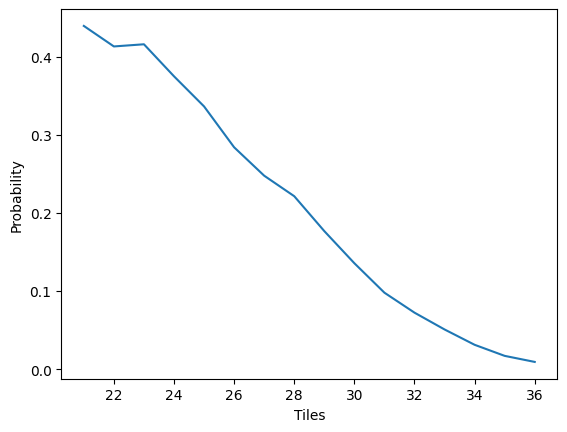

In [8]:
player_designed_for_this_question = Player_select_Tile_equal_score()

basic_r = [0]*16
tiles = []
maximum_probability = []
for i in range(16):
    temp = basic_r.copy()
    temp[i] = 1
    player_designed_for_this_question.set_r(temp)
    tiles.append(21 + i)
    maximum_probability.append(player_designed_for_this_question.expectancy(0,8,0))
    
plt.plot(tiles, maximum_probability, label="Maximum probability to reach the desired tile")
plt.xlabel("Tiles")
plt.ylabel("Probability")
plt.show()

... or Tile 27 or higher

In [9]:
player.set_r([0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1])
print(player.expectancy(0,8,0))

0.5247594468429357


We can compute this quantity for any score from 21 to 36

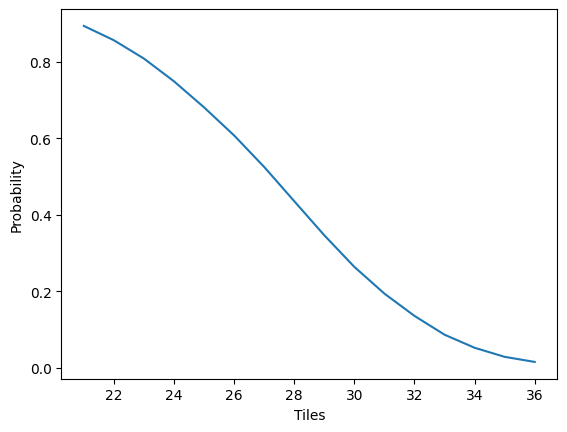

In [10]:
temp = [1]*16
tiles = []
probability = []
for i in range(16):
    if i:
        temp[i-1] = 0
    player.set_r(temp)
    tiles.append(21 + i)
    probability.append(player.expectancy(0,8,0))
    
plt.plot(tiles, probability, label="Probability to reach the desired tile or higher")
plt.xlabel("Tiles")
plt.ylabel("Probability")
plt.show()

## Part II

